### A Single Trial

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from multi_arm import Arm, monte_carlo_simulation, k_arm_bandit_mc, plot_history
import seaborn
# 5-arm figure: seed 6, 11
# 2-arm figure: seed 8

seed = 6
np.random.seed(seed)

In [13]:
ctrs = [0.04, 0.048, 0.03, 0.037, 0.044]
# ctrs = [0.04, 0.05]

true_winner_idx = np.argmax(ctrs)
print("true_winner_idx:", true_winner_idx, ctrs)

(winner_idx, est_ps, wins, traffic, history_ctr, history_p, history_idx, history_alphas, history_betas,
 values_remaining) = k_arm_bandit_mc(ctrs, alpha=0.05, burn_in=3000)

true_winner_idx: 1 [0.04, 0.048, 0.03, 0.037, 0.044]
Winning arm 1 beats second arm at iteration 64045


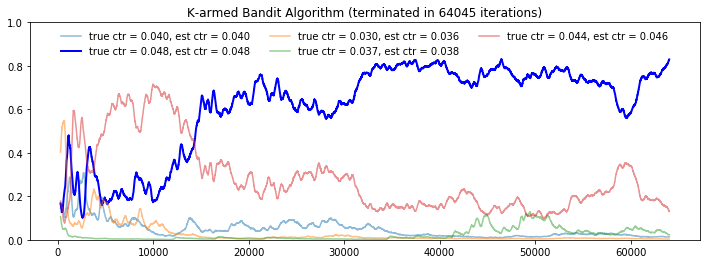

In [14]:
rolling=300
plot_history(ctrs, est_ps, history_p, 
             title="K-armed Bandit Algorithm (terminated in %i iterations)"%sum(traffic), rolling=rolling)

In [15]:
# turn winner's probability into data frame
cols = ["arm_%i_ctr=%.2f"%(i + 1, ctr) for i, ctr in enumerate(ctrs)]
data = {col : hist for col, hist in zip(cols, history_p)}
df_history_ma = pd.DataFrame(data).rolling(rolling).mean()

# turn click through ratre into data frame with same index, to be used as legend
data = {col : hist for col, hist in zip(cols, history_ctr)}
df_history_ctr = pd.DataFrame(data)

### ImageIO
* Quality is low, title and labels appear to be __bold__ and pixellated.

In [16]:
# import imageio

# def plot_history(ctrs, est_ctrs, df_history, title, x_lim, fname=None, transparent=False):
#     """
#     Plot evolution of conversion rates estimates or winner probability for each arm.
    
#     Parameters
#     ----------
#     ctr, est_ctrs list[float]: true ctrs and estiamted ctrs.
#     df_history list[list[float]]: a nested list of each arm's history.
#     rolling int: rolling window length.
#     fname str: enter file name if need to store, including '.png'.
#     transparent bool: make background transparent.
#     """
#     true_winner_idx = np.argmax(ctrs)
#     winner_idx = np.argmax(est_ctrs)

#     fig, ax = plt.subplots(figsize=(12,4))
#     for i, col in enumerate(cols):
#         if i == true_winner_idx :
#             ax.plot(df_history[col], lw=2, color='b')
#         elif i == winner_idx:
#             ax.plot(df_history[col], lw=2, color='r')
#         else:
#             ax.plot(df_history[col], alpha=0.5)
#     ax.grid()
#     ax.set(xlabel='iteration', ylabel='p_winner', title=title)
#     legend = ["true ctr = %.3f, est ctr = %.3f"%(true, est) for true, est in zip(ctrs, est_ctrs)]
#     ax.legend(legend, frameon=False, loc='upper center', ncol=3)
    
#     # IMPORTANT ANIMATION CODE HERE
#     # Used to keep the limits constant
#     ax.set_ylim(-0.1, 1)
#     ax.set_xlim(-0.05 * x_lim , x_lim * 1.05)

#     # Used to return the plot as an image rray
#     fig.canvas.draw()       # draw the canvas, cache the renderer
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     plt.close()
#     return image

In [17]:
# batch = 1000
# mistake = []
# images = []
# for i in range(len(history_idx) // batch + 1):
#     idx_end = min(len(history_idx) - 1, (i + 1) * batch)
#     print("progress %.2f%%"%(100 * idx_end / sum(traffic)), end='\r')
#     image = plot_history(
#         ctrs, 
#         df_history_ctr.iloc[idx_end].values, 
#         df_history_ma[:idx_end], 
#         x_lim=len(df_history_ma),
#         title="K-armed Bandit Algorithm (terminated in %i iterations)"%sum(traffic))
#     images.append(image)

In [18]:
# kwargs_write = {'fps':1.0, 'quantizer':'nq'}
# imageio.mimsave('outputs/animated_ctrs_imageio.gif', images, fps=48)

### FuncAnimation
* 5 seconds, 48 frames per seconds

In [19]:
fps = 48
duration = 3

In [20]:
batch = int(sum(traffic) / (duration * fps))
print("batch", batch)
frames = []
for i in range(len(history_idx) // batch + 1):
    idx_end = min(len(history_idx) - 1, (i + 1) * batch)
    frames.append(idx_end)
    
# frames = frames[:30]

batch 444


(-0.1, 1.1)

/Users/shawlu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


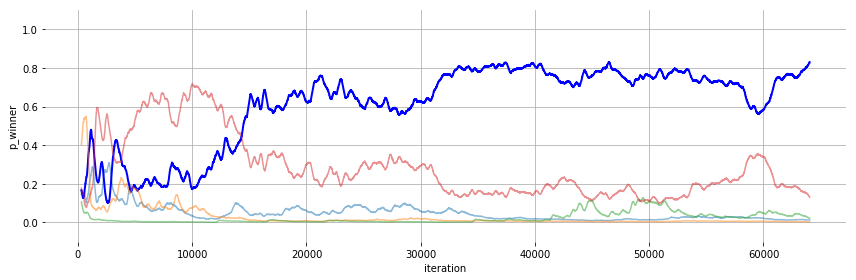

In [21]:
from matplotlib.animation import FuncAnimation

df_history = df_history_ma

color_dict = {}
lines = []
true_winner_idx = np.argmax(ctrs)
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)

for i, col in enumerate(df_history_ma.columns):
    if i == true_winner_idx :
        line, = ax.plot(df_history[col], lw=2, color='b')
    else:
        line, = ax.plot(df_history[col], alpha=0.5)
    lines.append(line)
    color_dict[line] = line.get_color()


for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax.grid()
ax.set(xlabel='iteration', ylabel='p_winner')
ax.set_ylim(-0.1, 1.1)

In [22]:
def update(i):
    print('iteration %i'%i, end="\r")
    est_ctrs = df_history_ctr.iloc[i].values
    winner_idx = np.argmax(est_ctrs)
    
    for idx, (col, line) in enumerate(zip(df_history_ma.columns, lines)):
        line.set_ydata(df_history_ma[col][:i])
        line.set_xdata(df_history_ma[col][:i].index.values)
        
        # highlight wrong arm in red, correct arm in blue
        # may appear messy if switching is frequent
        if idx == true_winner_idx:
            line.set_color('b')
            line.set_lw(2)
            line.set_alpha(1)
        elif idx == winner_idx:
            line.set_color('r')
            line.set_lw(2)
            line.set_alpha(1)
        else:
            line.set_color(color_dict[line])
            line.set_lw(1)
            line.set_alpha(0.5)

    ax.set_title("%i-armed Bandit Experiment (%i iterations)"%(len(ctrs), i))
        
    legend = ["true ctr = %.3f, est ctr = %.3f"%(true, est) for true, est in zip(ctrs, est_ctrs)]
    ax.legend(legend, frameon=False, loc='upper center', ncol=3)

    return line, ax

anim = FuncAnimation(fig, update, frames=frames, interval=1000 / fps)
fname = 'outputs/animated_ctrs_%is_%ifps_seed%i.gif'%(duration, fps, seed)
anim.save(fname, dpi=80, writer='imagemagick')
print(fname)

plt.close()

outputs/animated_ctrs_3s_48fps_seed6.gif
